In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

d:\Anaconda\envs\DataScience\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\Anaconda\envs\DataScience\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv("../data/keyword_jptiik.csv")

data_abs = data[["abstract"]]
data_abs.head()

,abstract
0,teknologi mixed reality akan membuat interaksi...
1,penjadwalan merupakan salah satu proses pentin...
2,untuk memenuhi kebutuhan masyarakat akan keter...
3,perusahaan mcdonald’s adalah perusahaan yang b...
4,perkembangan internet saat ini sangat pesat. d...


In [3]:
data_abs["abstract"] = data_abs["abstract"].str.strip()
data_abs["abstract"] = data_abs["abstract"].str.lower()
data_abs["abstract"] = data_abs["abstract"].str.replace('[^\w\s]','')
data_abs["abstract"] = data_abs["abstract"].str.replace('\d+', '')
data_abs["abstract"] = data_abs["abstract"].str.replace('\s+', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\n', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('\t', ' ')
data_abs["abstract"] = data_abs["abstract"].str.replace('  ', ' ')

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [5]:
stopword = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stopword.remove(x))
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: stemmer.stem(x))

In [6]:
import random

In [7]:
vocab = set()
max_tokens = 10000

for abstract in data_abs["abstract"]:
    for word in abstract.split():
        vocab.add(word)
    
vocab = list(vocab)
random.shuffle(vocab)
vocab = vocab[:max_tokens]
vocab += ["<UNK>"]

data_abs["abstract"] = data_abs["abstract"].apply(lambda x: x.split())
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: [word if word in vocab else "<UNK>" for word in x])
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: " ".join(x))

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [8]:
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: [word2idx[word] for word in x.split()])

In [9]:
# mean length of abstract
MAX_LENGTH = round(sum([len(abstract) for abstract in data_abs["abstract"]]) / len(data_abs["abstract"]))

# padding and truncate
data_abs["abstract"] = data_abs["abstract"].apply(lambda x: x + [0] * (MAX_LENGTH - len(x)) if len(x) < MAX_LENGTH else x[:MAX_LENGTH])
# data_abs["abstract"] = data_abs["abstract"].apply(lambda x: torch.tensor(x).float())

In [15]:
data_abs = data_abs["abstract"].apply(pd.Series)
data_abs

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,10000,10000,6803,3289,5772,10000,10000,1600,10000,3668,...,0,0,0,0,0,0,0,0,0,0
1,7441,10000,10000,4519,5969,10000,4519,4562,7441,4519,...,0,0,0,0,0,0,0,0,0,0
2,7144,381,8923,3928,10000,10000,10000,4725,8561,7843,...,0,0,0,0,0,0,0,0,0,0
3,1951,6417,1951,4032,10000,10000,10000,10000,10000,6417,...,10000,10000,6183,10000,583,6417,7058,6510,8820,10000
4,10000,9254,7180,8799,4190,6192,10000,10000,10000,10000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,10000,7567,8107,7059,955,10000,176,1951,7440,7567,...,1420,4562,6545,8135,8513,2344,10000,5975,3360,10000
3475,10000,10000,7363,1675,5070,10000,10000,4402,4593,10000,...,10000,10000,10000,10000,10000,5772,5040,4556,10000,10000
3476,9656,2374,6377,5085,7352,10000,421,1548,8527,2374,...,57,10000,7466,6671,10000,9703,10000,4808,5101,8924
3477,7630,5022,7069,8452,10000,10000,3680,8452,10000,1305,...,1273,10000,10000,10000,10000,10000,10000,10000,10000,8135


In [16]:
data_abs.shape

(3479, 109)

In [17]:
VOCAB_SIZE = len(vocab)

In [111]:
data_abs = data_abs.to_numpy()
data_abs = torch.tensor(data_abs).float()
data_abs

tensor([[10000., 10000.,  6803.,  ...,     0.,     0.,     0.],
        [ 7441., 10000., 10000.,  ...,     0.,     0.,     0.],
        [ 7144.,   381.,  8923.,  ...,     0.,     0.,     0.],
        ...,
        [ 9656.,  2374.,  6377.,  ...,  4808.,  5101.,  8924.],
        [ 7630.,  5022.,  7069.,  ..., 10000., 10000.,  8135.],
        [ 1345.,  5375., 10000.,  ...,     0.,     0.,     0.]])

In [277]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(109, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.fc6 = nn.Linear(4, 2)
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc4(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        # x = self.fc6(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc6 = nn.Linear(2, 4)
        self.fc5 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc1 = nn.Linear(64, 109)
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.selu = nn.SELU()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x = self.fc6(x)
        # x = self.gelu(x)
        # x = self.fc5(x)
        # x = self.gelu(x)
        x = self.fc4(x)
        x = self.gelu(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.fc1(x)

        return x

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [286]:
E = Encoder()
D = Decoder()
AE = AutoEncoder(E, D)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(AE.parameters(), lr=0.01)

for epoch in range(400):
    
    abstract = data_abs
    optimizer.zero_grad()
    output = AE(abstract)
    loss = criterion(output, abstract)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(6305.2998, grad_fn=<SmoothL1LossBackward0>)
tensor(6255.2427, grad_fn=<SmoothL1LossBackward0>)
tensor(6034.0371, grad_fn=<SmoothL1LossBackward0>)
tensor(5353.8848, grad_fn=<SmoothL1LossBackward0>)
tensor(3975.8350, grad_fn=<SmoothL1LossBackward0>)
tensor(4331.6250, grad_fn=<SmoothL1LossBackward0>)
tensor(3149.4958, grad_fn=<SmoothL1LossBackward0>)
tensor(3184.4971, grad_fn=<SmoothL1LossBackward0>)
tensor(3364.4353, grad_fn=<SmoothL1LossBackward0>)
tensor(3313.0901, grad_fn=<SmoothL1LossBackward0>)
tensor(3142.8799, grad_fn=<SmoothL1LossBackward0>)
tensor(3260.5630, grad_fn=<SmoothL1LossBackward0>)
tensor(3279.6860, grad_fn=<SmoothL1LossBackward0>)
tensor(3046.3325, grad_fn=<SmoothL1LossBackward0>)
tensor(3082.2578, grad_fn=<SmoothL1LossBackward0>)
tensor(3060.4976, grad_fn=<SmoothL1LossBackward0>)
tensor(2955.0232, grad_fn=<SmoothL1LossBackward0>)
tensor(2946.3789, grad_fn=<SmoothL1LossBackward0>)
tensor(3021.0125, grad_fn=<SmoothL1LossBackward0>)
tensor(2904.3281, grad_fn=<Smoo

In [287]:
latent_representation = AE.encoder(data_abs)
latent_representation.shape

torch.Size([3479, 8])

In [288]:
# to dataframe
latent_df = pd.DataFrame(latent_representation.detach().numpy())
latent_df

,0,1,2,3,4,5,6,7
0,-909.783325,-950.532410,-4519.610840,-4930.100098,-5779.096680,4563.877930,-5874.512207,-1546.046753
1,-2089.841309,-1414.946411,-10318.601562,-10862.200195,-12342.676758,9896.837891,-12584.500977,-3359.128174
2,-2870.140625,-1970.604370,-14371.133789,-15093.002930,-17222.441406,13810.471680,-17588.427734,-4653.149902
3,-2985.178711,-2067.191406,-14753.889648,-15568.622070,-17701.867188,14213.606445,-18085.968750,-4776.508301
4,-2826.069580,-1886.504272,-14018.332031,-14736.161133,-16740.306641,13442.703125,-17096.068359,-4533.551758
...,...,...,...,...,...,...,...,...
3474,-3135.237793,-2150.025635,-15484.214844,-16330.974609,-18554.574219,14903.908203,-18958.759766,-5007.700684
3475,-3387.182129,-2337.750488,-16688.673828,-17619.191406,-20014.142578,16067.435547,-20437.785156,-5413.068848
3476,-3250.553467,-2239.685059,-16040.527344,-16928.685547,-19233.177734,15448.192383,-19652.103516,-5190.186523
3477,-3105.668457,-2124.171143,-15362.728516,-16195.063477,-18403.238281,14781.841797,-18805.427734,-4967.138672


In [294]:
JUMLAH_PEMINATAN = 6
k_means = KMeans(n_clusters=JUMLAH_PEMINATAN).fit(latent_representation.detach().numpy())
labels = k_means.labels_

In [295]:
data["labels"] = labels

In [296]:
data["labels"].value_counts()

4    1289
2     891
0     709
5     329
1     195
3      66
Name: labels, dtype: int64

In [297]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representation.detach().numpy())

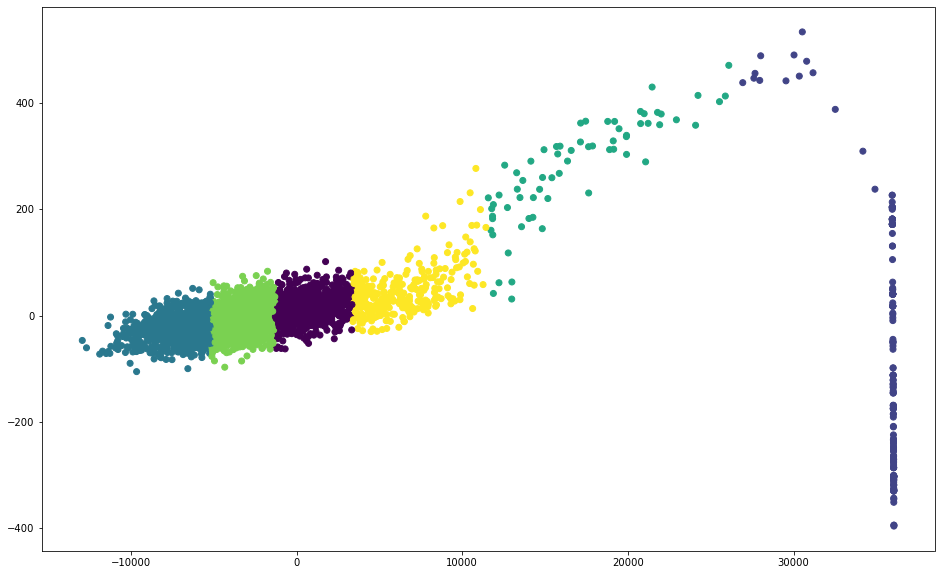

In [298]:
plt.figure(figsize=(16,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=labels)
plt.show()

In [301]:
data.to_csv("../data/cluster_poc dhe_jptiik.csv", index=False)

In [302]:
torch.save(AE.state_dict(), "../model/ae_poc dhe_jptiik.pt")

In [303]:
torch.save(AE, "../model/full_ae_poc dhe_jptiik.pt")

In [304]:
model2 = torch.load("../model/full_ae_poc dhe_jptiik.pt")